## Loading data

The dataset of Ryan Moore has been used [https://nd013.s3.amazonaws.com/track1.zip](here)

The dataset has two folders 'driving' folder and 'recovery' folder. Currently the driving folder is used only.

The driving folder contains csv file for steering measurements and IMG folder. The images are in three colums, snapped from center, right and left cameras. They have a corresponding steering angle – the steer the car had to make in that frame to stay on the track. We load both into images[ ] and measurements[ ] arrays. 
The csv file named 'driving_log.csv' has 7874 x 7 data entries. We are interested in the first 4 columns. 

Center image path | Left image path | Right image path | Steering angle range (-1,+1)

if steering <0 : steering to left , if steering > 0 : seering to right, steering = 0 : idle 


In [1]:
import csv
import cv2
import numpy as np
import math

lines = []
with open('./project3/track1/drive/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
correction = 0.2
counter = 0

#math.ceil(float(len(lines))/2)

for line in lines[:6500]:
    source_path = line[0]
    source_path_left = line[1]
    source_path_right = line[2]
    tokens = source_path.split('/')
    filename = tokens[-1]
    local_path = "./project3/track1/drive/IMG/" + filename
    tokens_left = source_path_left.split('/')
    filename_left = tokens_left[-1]
    local_path_left = "./project3/track1/drive/IMG/" + filename_left
    tokens_right = source_path_right.split('/')
    filename_right = tokens_right[-1]
    local_path_right = "./project3/track1/drive/IMG/" + filename_right
    image = cv2.imread(local_path)
    image_left = cv2.imread(local_path_left)
    image_right = cv2.imread(local_path_right)
    measurement = line[3]
    if float(measurement) == 0:
        # if stearing = 0 ignore 5 out of 6 of the images, since they are roughly 6 times more than the others
        counter += 1
        if counter == 10:
            counter == 0
            images.append(image)
            images.append(image_left)
            images.append(image_right)
            measurements.append(float(measurement))
            measurements.append(float(measurement)+correction) # Add correction for steering for left images
            measurements.append(float(measurement)-correction) # Minus correction for steering for right images
    else:
        images.append(image)
        images.append(image_left)
        images.append(image_right)
        measurements.append(float(measurement))
        measurements.append(float(measurement)+correction) # Add correction for steering for left images
        measurements.append(float(measurement)-correction) # Minus correction for steering for right images



#### Adding recovery set of images

In [2]:
lines = []
with open('./project3/track1/recovery/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

for line in lines:
    source_path = line[0]
    source_path_left = line[1]
    source_path_right = line[2]
    tokens = source_path.split('/')
    filename = tokens[-1]
    local_path = "./project3/track1/recovery/IMG/" + filename
    tokens_left = source_path_left.split('/')
    filename_left = tokens_left[-1]
    local_path_left = "./project3/track1/recovery/IMG/" + filename_left
    tokens_right = source_path_right.split('/')
    filename_right = tokens_right[-1]
    local_path_right = "./project3/track1/recovery/IMG/" + filename_right
    image = cv2.imread(local_path)
    image_left = cv2.imread(local_path_left)
    image_right = cv2.imread(local_path_right)
    measurement = line[3]
    if float(measurement) == 0:
        # if stearing = 0 ignore 5 out of 6 of the images, since they are roughly 6 times more than the others
        counter += 1
        if counter == 10:
            counter == 0
            images.append(image)
            images.append(image_left)
            images.append(image_right)
            measurements.append(float(measurement))
            measurements.append(float(measurement)+correction) # Add correction for steering for left images
            measurements.append(float(measurement)-correction) # Minus correction for steering for right images
    else:
        images.append(image)
        images.append(image_left)
        images.append(image_right)
        measurements.append(float(measurement))
        measurements.append(float(measurement)+correction) # Add correction for steering for left images
        measurements.append(float(measurement)-correction) # Minus correction for steering for right images

X_train = np.array(images)
y_train = np.array(measurements, dtype = 'float32')

In [3]:
print(X_train.shape, y_train.shape)

(14688, 160, 320, 3) (14688,)


#### Showing an example of an image (the last image)

In [4]:
iii = cv2.imread(local_path)

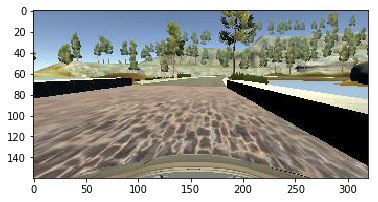

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(cv2.cvtColor(iii, cv2.COLOR_RGB2BGR))

#### Augmenting the dataset with vertically flipped images

In [6]:
images_flipped = []

for image in images:
    images_flipped.append(cv2.flip(image,1))

X_train = np.vstack((X_train,np.array(images_flipped)))
y_train_flipped = y_train * -1.
y_train = np.concatenate((y_train, y_train_flipped ))

In [7]:
print(X_train.shape, y_train.shape)

(29376, 160, 320, 3) (29376,)


#### Plot  dataset histogram

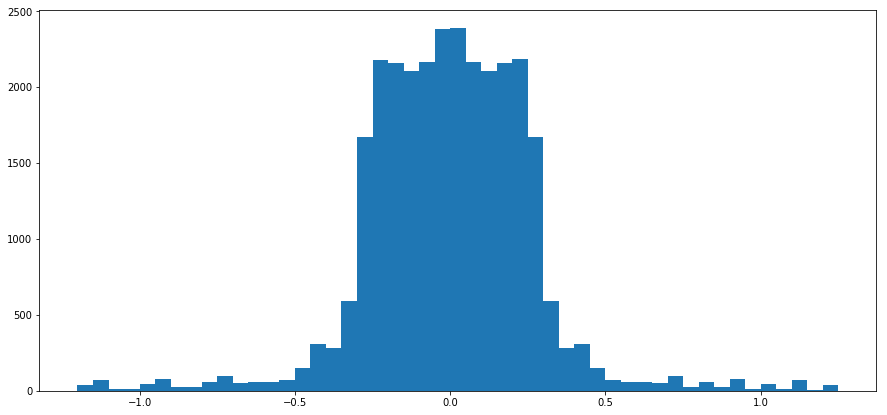

In [8]:


binwidth = 0.05
plt.figure(figsize=(15,7))
plt.hist(y_train, bins=np.arange(min(y_train), max(y_train) + binwidth, binwidth))

plt.show()

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D


model = Sequential()

# Normalizing lambda layer
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))

# Cropping out the sky which makes about 70 pixels at the top of the frame, and the dashboard about 25 pixels at the bottom
model.add(Cropping2D(cropping=((70,25),(1,1))))

# First convolutional layer
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())

# Second convolutional layer
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())

# Fully-connected layers
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_split=0.02, shuffle=True , verbose = 2, nb_epoch = 5)
model.save('model.h5')

Using TensorFlow backend.


Train on 28788 samples, validate on 588 samples
Epoch 1/5
52s - loss: 0.0506 - val_loss: 0.3422
Epoch 2/5
50s - loss: 0.0248 - val_loss: 0.3054
Epoch 3/5
50s - loss: 0.0222 - val_loss: 0.2817
Epoch 4/5
50s - loss: 0.0213 - val_loss: 0.2956
Epoch 5/5
50s - loss: 0.0204 - val_loss: 0.2668


In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 318, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 61, 314, 6)    456         cropping2d_1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 30, 157, 6)    0           convolution2d_1[0][0]            
___________________________________________________________________________________________

#### Loading the Keras model and making a visualization of the model

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import plot_model
from keras.models import load_model


model = load_model('model.h5')

plot_model(model, to_file='model.png')


C:\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\topology.py:1206: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(5, 5), kernel_constraint=None, activity_regularizer=None, kernel_regularizer=None, use_bias=True, trainable=True, filters=6, data_format="channels_last", name="convolution2d_1", bias_regularizer=None, padding="valid", kernel_initializer="glorot_uniform", bias_constraint=None, strides=[1, 1], activation="relu")`
  return cls(**config)
C:\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\topology.py:1206: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(strides=[2, 2], name="maxpooling2d_1", padding="valid", trainable=True, data_format="channels_last", pool_size=[2, 2])`
  return cls(**config)
C:\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\topology.py:1206: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(5, 5), kernel_constraint=None, activity_regul

ValueError: Optimizer weight shape (6,) not compatible with provided weight shape (5, 5, 3, 6)

In [6]:
print(tf.version)

NameError: name 'tf' is not defined

In [17]:
help(visualize_util)

NameError: name 'visualize_util' is not defined